In [ ]:
__author__ = "Yasaman Emami"
__email__ = ['emami.yasamann@gmail.com','yasaman.emami@sjsu.edu']

Import Libraries

In [ ]:
from keras.datasets import cifar10
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Layer, Flatten, Reshape, Conv2DTranspose, Lambda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import metrics, losses


Load Dataset

In [ ]:
#Load CIFAR-10 data set

(x_train, y_train), (x_test, _) = cifar10.load_data()
#Print train and test data and size

print("train data", x_train.shape)
print("test data", x_test.shape)

batch_size = 50
img_width, img_height, img_channels = 32, 32, 3
no_classes = 10
no_epochs = 50

#normalize the data & build Autoencoder pipeline & display model summary

#define the input shape
input_img = Input(shape = (img_width, img_height, img_channels))

# convert to float32 format
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the data
x_train = x_train / 255.
x_test = x_test / 255.

train data (50000, 32, 32, 3)
test data (10000, 32, 32, 3)


Create Sampling Layer

In [ ]:
'''

source: https://keras.io/examples/generative/vae/

'''

'\n\nsource: https://keras.io/examples/generative/vae/\n\n'

In [ ]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding an item."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Build Encoder

In [ ]:
latent_dim = 2


x = Conv2D(512, (3, 3), activation='relu', padding='same') (input_img)
x = MaxPooling2D((2, 2)) (x)

x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
x = MaxPooling2D((2, 2)) (x)

x = Conv2D(128, (3, 3), activation='relu', padding='same') (x)
x = MaxPooling2D((2, 2)) (x)

x = Conv2D(64, (3, 3), activation='relu', padding='same') (x)
x = MaxPooling2D((2, 2)) (x)

x = Conv2D(32, (3, 3), activation='relu', padding='same') (x)
x = MaxPooling2D((2, 2)) (x)

x = Conv2D(16, (3, 3), activation='relu', padding='same') (x)
# x = MaxPooling2D((2, 2)) (x)

x = Conv2D(8, (3, 3), activation='relu', padding='same') (x)
# x = MaxPooling2D((2, 2)) (x)
x = Flatten()(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoded = Model(input_img, [z_mean, z_log_var, z], name="encoder")
encoded.summary()
# encoded = MaxPooling2D((2, 2)) (x)




Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_46 (Conv2D)             (None, 32, 32, 512)  14336       ['input_20[0][0]']               
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 16, 16, 512)  0          ['conv2d_46[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 16, 16, 256)  1179904     ['max_pooling2d_38[0][0]'] 

Build Decoder

In [ ]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(1 * 1 * 8, activation="relu")(latent_inputs)
x = Reshape((1, 1, 8))(x)

x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same') (x)
x = UpSampling2D((2, 2)) (x)

x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same') (x)
x = UpSampling2D((2, 2)) (x)

x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same') (x)
x = UpSampling2D((2, 2)) (x)

x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same') (x)
x = UpSampling2D((2, 2)) (x)

x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same') (x)
x = UpSampling2D((2, 2)) (x)


# x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same') (x)
# x = UpSampling2D((2, 2)) (x)


# x = Conv2DTranspose(512, (3, 3), activation='relu', padding='same') (x)
# x = MaxPooling2D((2, 2)) (x)

decoder_outputs = Conv2DTranspose(3, 3, activation="softmax", padding="same")(x)

decoded = Model(latent_inputs, decoder_outputs, name="decoder")
decoded.summary()
# decoded = Conv2D(3, (3, 3), padding='same') (x)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_23 (Dense)            (None, 8)                 24        
                                                                 
 reshape_13 (Reshape)        (None, 1, 1, 8)           0         
                                                                 
 conv2d_transpose_84 (Conv2D  (None, 1, 1, 8)          584       
 Transpose)                                                      
                                                                 
 up_sampling2d_64 (UpSamplin  (None, 2, 2, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose_85 (Conv2D  (None, 2, 2, 16)         1168

Define the VAE as a Model with a custom train_step

In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            data = tf.cast(data, tf.float32)
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         tfp.distributions.MultivariateNormalDiag(
            #             layers.Flatten()(reconstruction), scale_identity_multiplier=0.05).log_prob(layers.Flatten()(data)
            #     )
            # ))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # kl_loss = tf.keras.metrics.kullback_leibler_divergence(data, reconstruction)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=[1]))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Train VAE

In [ ]:
cifar = np.concatenate([x_train, x_test], axis=0)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
print(x_train.shape)
vae = VAE(encoded, decoded)
vae.compile(optimizer='adam')
vae.fit(cifar, epochs=100, batch_size=128)
print(x_train.shape)
print(x_test.shape)


(50000, 32, 32, 3)
Epoch 1/100
469/469 [==============================] - 29s 58ms/step - loss: 684.8542 - reconstruction_loss: 665.1818 - kl_loss: 3.5802
Epoch 2/100
469/469 [==============================] - 27s 57ms/step - loss: 655.6526 - reconstruction_loss: 651.0784 - kl_loss: 4.1630
Epoch 3/100
469/469 [==============================] - 28s 60ms/step - loss: 654.7843 - reconstruction_loss: 650.5775 - kl_loss: 4.2807
Epoch 4/100
469/469 [==============================] - 27s 57ms/step - loss: 655.0215 - reconstruction_loss: 650.2675 - kl_loss: 4.4618
Epoch 5/100
469/469 [==============================] - 27s 57ms/step - loss: 654.7099 - reconstruction_loss: 650.2840 - kl_loss: 4.5700
Epoch 6/100
469/469 [==============================] - 27s 57ms/step - loss: 655.0526 - reconstruction_loss: 650.3416 - kl_loss: 4.7346
Epoch 7/100
469/469 [==============================] - 27s 57ms/step - loss: 655.8075 - reconstruction_loss: 651.5242 - kl_loss: 4.8163
Epoch 8/100
469/469 [========

Display samples latent space

[-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]
1/1 [==============================] - 0s 14ms/step


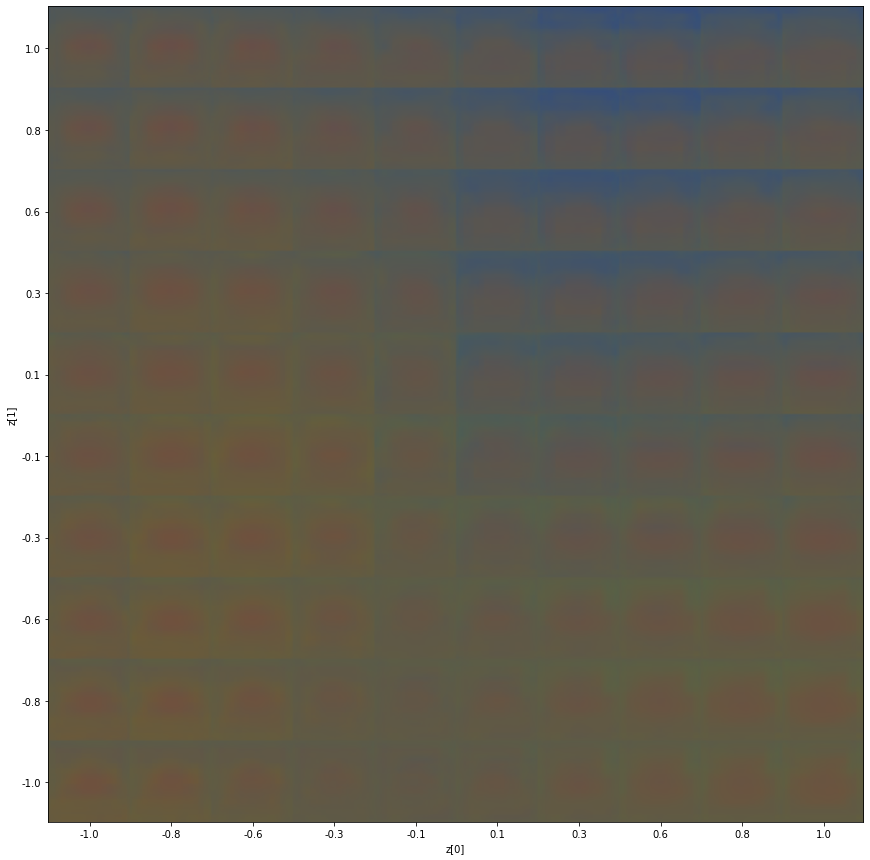

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D 
    image_size = 32
    scale = 1.0
    figure = np.zeros((image_size * n, image_size * n,3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of cifar classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    print(grid_x)
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            cifar = x_decoded[0].reshape(image_size, image_size,3)
            figure[
                i * image_size : (i + 1) * image_size,
                j * image_size : (j + 1) * image_size
            ] = cifar

    plt.figure(figsize=(figsize, figsize))
    start_range = image_size // 2
    end_range = n * image_size + start_range
    pixel_range = np.arange(start_range, end_range, image_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent_space(vae)

Display latent space clusters for different classes

1563/1563 [==============================] - 7s 5ms/step


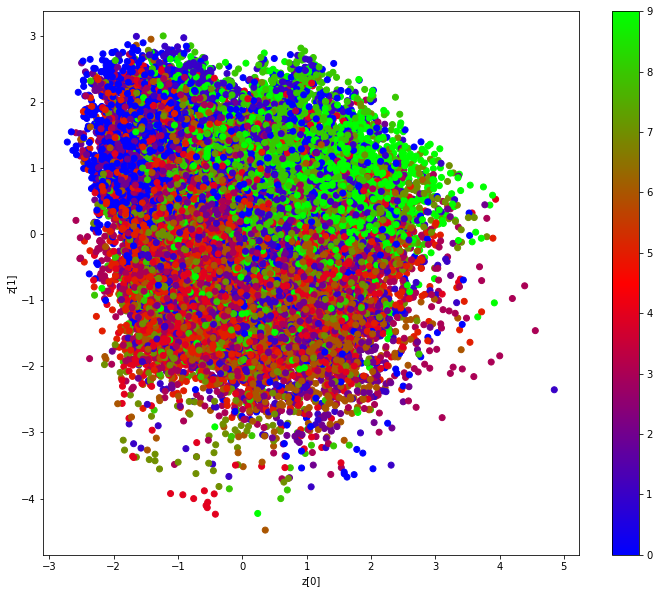

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    
    # y_labels = {0: 'airplane',1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
    # from sklearn.manifold import TSNE
 
    # X_embedded = TSNE(n_components=2, learning_rate='auto',
    #                init='random', perplexity=3).fit_transform(d2_train_dataset[1])

    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='brg')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()




plot_label_clusters(vae, x_train, y_train)


Display 10 random reconstructed images

1/1 [==============================] - 0s 15ms/step


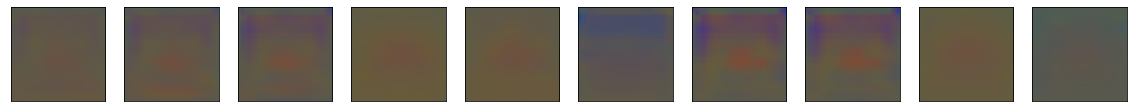

In [ ]:
import random

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):

    # Display reconstruction
    x_val = random.uniform(-5, 3)
    y_val = random.uniform(-5, 3)
    sample_latent_vector = np.array([[x_val,x_val]])
    #predict the image from the specific range, hope this will be a 0
    #we need to reshape to plot it
    decoder_example = vae.decoder.predict(sample_latent_vector).reshape(32,32,3)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoder_example.reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
  

  # however, we can plot some noise from the distribution, in that case 
  # you can select the range 

**MODEL #2 with less than 3 conv layers**

In [ ]:
from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import matplotlib.pyplot as plt

In [ ]:
# importing the dataset
from keras.datasets import cifar10
import numpy as np
(x_train, _), (x_test, _) = cifar10.load_data() # do not need the y label

In [ ]:
# data preprocessing ==> normaliztion 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# check the shape of the data
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
# it is two dimensional, we can feed the data in 2-D or in 1-D format
# lets do it with one-D 
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [ ]:
original_dim = 32 * 32 * 3
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
# inputs = layers.Dense(128, activation='relu')(inputs)
h = Dense(intermediate_dim, activation='relu')(inputs)
# generate the mean vector 
z_mean = Dense(latent_dim)(h)
# generate the sigma vector 
z_log_sigma = Dense(latent_dim)(h)

In [ ]:
from keras import backend as K
# define the sampling function: input mean vector and std vector 
# mean and std vector will be computed from the encoder
# write a customer layer 
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
import keras
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #an encoder mapping inputs to the latent space

In [ ]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
# x = layers.Dense(128, activation='sigmoid')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)
#a generator that can take points on the latent space and will output the corresponding reconstructed samples.
decoder = keras.Model(latent_inputs, outputs, name='decoder') 

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                192       
                                                                 
 dense_9 (Dense)             (None, 3072)              199680    
                                                                 
Total params: 199,872
Trainable params: 199,872
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp') # an end-to-end autoencoder mapping inputs to reconstructions

In [ ]:
# reconstruction loss: can be binary crossentropy or MSE 
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

In [ ]:
# KL divergence Loss
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

In [ ]:
#total loss 
vae_loss = K.mean(reconstruction_loss + kl_loss)

#addition loss to the model 
vae.add_loss(vae_loss)

# compiling the model 
vae.compile(optimizer='adam')

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
x_test.shape

(10000, 3072)

In [ ]:
vae.fit(x_train, x_train,
        epochs=1,
        batch_size=32,
        validation_data=(x_test, x_test))

1563/1563 [==============================] - 23s 14ms/step - loss: 1976.7727 - val_loss: 1958.3101


In [ ]:
mu,_,_ = encoder.predict(x_test)


313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


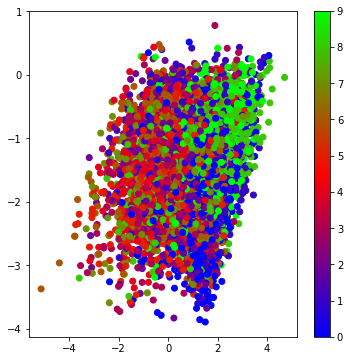

In [ ]:
# Because our latent space is two-dimensional, we can take a look
# at the neighborhoods of different classes on the latent 2D plane:
x_test_encoded = encoder.predict(x_test, batch_size= 32)
plt.figure(figsize=(6, 6))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap = 'brg')
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 20ms/step


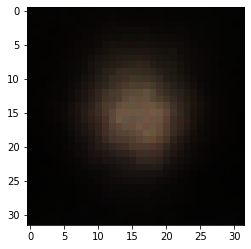

In [ ]:
# now we can visulalize the image from different portion of the distribution 
# as we can the different classes in different distribution zone 
# here the latent space zone is -3 to 3 in both direction 
# we can customize the zone and then can generate some new data 
# for instance, we can take the range for digit 0, it seems dark blue color in the plot 
# and the range seems to 

for _ in range(5):
  sample_latent_vector = np.array([[1.9,1]])
  sample_latent_vector = np.array([[1.1,-2.3]])
  sample_latent_vector = np.array([[2.9,1]])
  sample_latent_vector = np.array([[1.9,-1]])
  sample_latent_vector = np.array([[-1.1,2.3]])
  #predict the image from the specific range, hope this will be a 0
  #we need to reshape to plot it
  decoder_example = decoder.predict(sample_latent_vector).reshape(32,32,3)
  plt.imshow(decoder_example)

  # however, we can plot some noise from the distribution, in that case 
  # you can select the range 

1/1 [==============================] - 0s 20ms/step


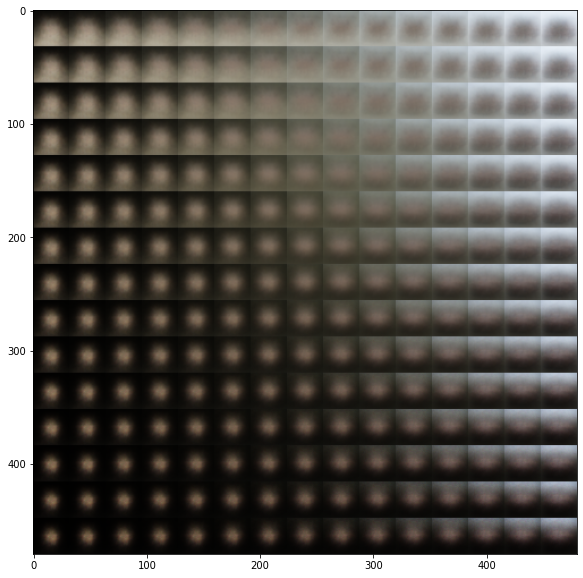

In [ ]:
# Display a 2D samples from latent space
n = 15  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n,3))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size,3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()